In [1]:
import numpy as np
import pandas as pd
from scipy.special import logit, expit
from scipy.stats import bernoulli
from matplotlib import pyplot as plt
import pymc as pm
import arviz as az
from modeltools import mcmc_diagnostics, create_summary_stat
from downcast import downcast_df

In [2]:
hoyle_data = pd.read_csv("data/hoyle_automated_2021.csv")
hoyle_data = (
    hoyle_data[hoyle_data["task"]=="intrusions"]
    .drop(columns=[c for c in hoyle_data.columns if c[1]=="_"])
    .rename(columns={"dataset":"corpus", "topic_idx":"topic",
                     "human_idx":"rater", "scores_raw":"intrusion",
                     "confidences_raw":"confidence"})
    ).drop(columns=["task"])

In [3]:
corpus_ids = (hoyle_data.groupby(["corpus"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
corpus_ids["corpus_id"] = corpus_ids.index

model_ids = (hoyle_data.groupby(["model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
model_ids["model_id"] = model_ids.index

cordel_ids = (hoyle_data.groupby(["corpus", "model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
cordel_ids["cordel_id"] = cordel_ids.index 

# topic_ids = (hoyle_data.groupby(["corpus", "model", "topic"], as_index=False)
#     .agg({"intrusion":"count"})
#     .drop(columns="intrusion"))
# topic_ids["topic_id"] = topic_ids.index 

rater_ids = (hoyle_data.groupby(["corpus", "rater"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
rater_ids["rater_id"] = rater_ids.index 


d1 = pd.merge(hoyle_data, corpus_ids, on=["corpus"], how="left")
d2 = pd.merge(d1, model_ids, on=["model"], how="left")
d3 = pd.merge(d2, cordel_ids, on=["corpus","model"], how="left")
d4 = pd.merge(d3, rater_ids, on=["corpus", "rater"], how="left")
# Topic ids are no longer 0 - 299
# data = pd.merge(d4, topic_ids, on=["corpus", "model", "topic"], how="left")
data = d4.rename(columns={"topic" : "topic_id"})
data = data[["corpus_id", "model_id", "cordel_id", "topic_id", "rater_id", "intrusion", "confidence"]]
data, na_s = downcast_df(data)

In [4]:
# Setting up numpy arrays for pymc
corpus_array = np.array(data["corpus_id"])
n_corpora = data["corpus_id"].nunique()

model_array = np.array(data["model_id"])
n_models = data["model_id"].nunique()

cordel_array = np.array(data["cordel_id"])
n_cordels = data["cordel_id"].nunique()

topic_array = np.array([data["cordel_id"], data["topic_id"]])
n_topics = data["topic_id"].nunique()

rater_array = np.array(data["rater_id"])
n_raters = data["rater_id"].nunique()

score_array = np.array(data["intrusion"])

## Model

In [5]:
# Model and MCMC specifications

n_cores = 2
empirical_mean = logit(0.75)
r_lambda = 2
t_lambda = 1
t_sigma = 1
# cm_lambda = 2
# cm_sigma = 1
mu_sigma = 1

In [6]:
# Collection of model, trace, prior & posterior simulations
# {"model": pm.Model, 
#  "trace": az.InferenceData, 
#  "prior_sim": az.InferenceData, 
#  "postrr_sim": az.InferenceData}

glm_topic = {"model":pm.Model()}
glm_rater_topic = {"model":pm.Model()}

In [7]:
np.ones(6).reshape(1,-1)

array([[1., 1., 1., 1., 1., 1.]])

In [8]:
# Topic only model

glm_topic["model"] = pm.Model()
with glm_topic["model"]:
    # Hyperparameter priors
    topics = pm.Data("topics", topic_array, mutable=True, dims=["cordel", "topic"])
    cordels = pm.Data("cordels", cordel_array, mutable=True, dims="obs_id")
    
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
    za = pm.Normal("za",mu=0, sigma=t_sigma, shape=(n_cordels, n_topics)) 
    mu = pm.Normal("mu",mu=empirical_mean, sigma=mu_sigma)
    
    s = pm.Bernoulli(
            "s", 
            p=pm.math.invlogit(
                mu+
                za[topics[0],topics[1]]*sigma_a),
            observed=score_array, 
            dims="obs_id")

    c_mean = pm.Deterministic("c_mean", 
                              pm.math.invlogit(mu + za*sigma_a).mean(axis=1), 
                              dims="obs_id")
    c_diff = pm.Deterministic("c_diff", c_mean.reshape([n_cordels,1]) - c_mean.reshape([1,n_cordels]), dims="obs_id")
    
    glm_topic["trace"]=pm.sample(cores=n_cores)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 85 seconds.


In [26]:
glm_topic["summary_stat"] = create_summary_stat(glm_topic["trace"], stat_funcs={"crit_val":lambda x:(x<0).sum()/x.shape[0]})

/home/roger/anaconda3/envs/bayes_topic_measures/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/roger/anaconda3/envs/bayes_topic_measures/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/roger/anaconda3/envs/bayes_topic_measures/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/roger/anaconda3/envs/bayes_topic_measures/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) 

In [27]:
glm_topic["summary_stat"][glm_topic["summary_stat"]["param"]=="c_diff"]

,param,param_num,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,crit_val
308,c_diff,"0, 0",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2000.0000,2000.0000,NaN,0.0000
309,c_diff,"0, 1",0.0931,0.0153,0.0645,0.1215,0.0002,0.0002,4223.5537,1488.5283,1.0035,0.0000
310,c_diff,"0, 2",0.0327,0.0145,0.0063,0.0612,0.0002,0.0002,4512.2982,1458.2466,0.9998,0.0110
311,c_diff,"0, 3",-0.0041,0.0143,-0.0332,0.0202,0.0002,0.0004,4632.7974,1370.0831,1.0007,0.6145
312,c_diff,"0, 4",0.0402,0.0146,0.0109,0.0650,0.0002,0.0002,5454.7521,1326.0409,0.9996,0.0035
313,c_diff,"0, 5",0.0282,0.0152,0.0005,0.0565,0.0002,0.0002,4689.0402,1404.4482,0.9996,0.0300
314,c_diff,"1, 0",-0.0931,0.0153,-0.1215,-0.0645,0.0002,0.0002,4223.5537,1488.5283,1.0035,1.0000
315,c_diff,"1, 1",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2000.0000,2000.0000,NaN,0.0000
316,c_diff,"1, 2",-0.0605,0.0148,-0.0888,-0.0334,0.0002,0.0002,4497.8492,1154.8302,1.0006,1.0000
317,c_diff,"1, 3",-0.0973,0.0148,-0.1235,-0.0690,0.0002,0.0002,4555.9898,1400.1884,0.9997,1.0000


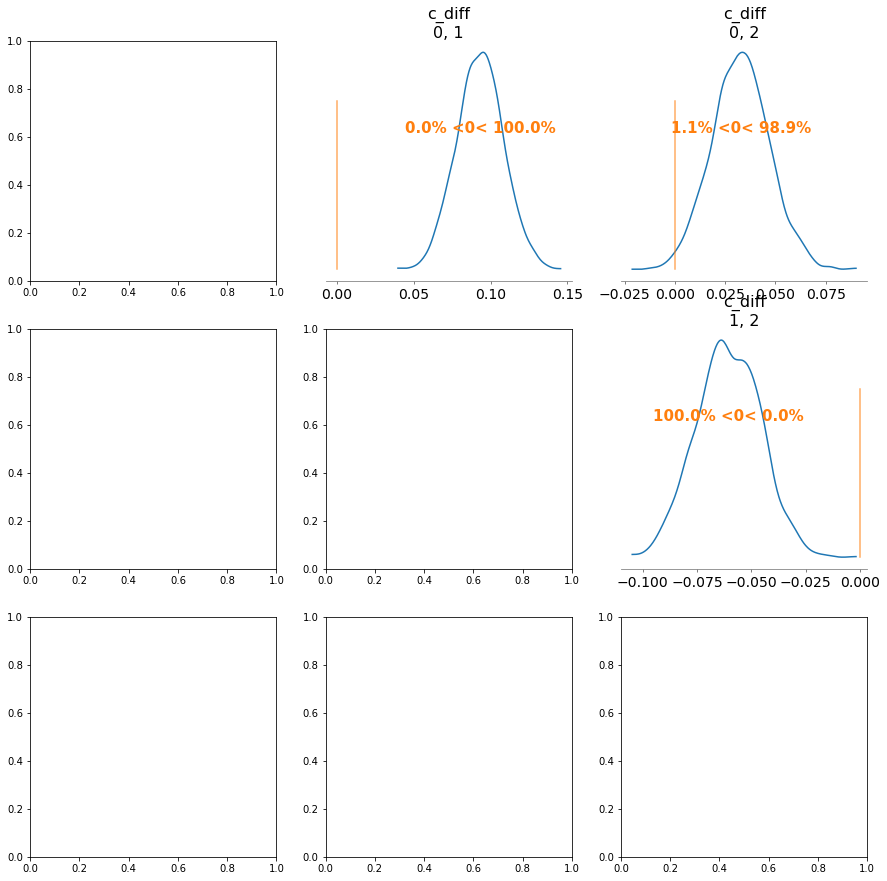

In [67]:
fig, axs = plt.subplots(3, 3, figsize=(15,15))
# axs[0, 0].plot(x, y)

for pair in [(0,1),(0,2),(1,2)]:
    coord={"obs_id":[pair[0]], "c_diff_dim_1":[pair[1]]}
    az.plot_posterior(glm_topic["trace"], var_names="c_diff", coords=coord, 
                      ref_val=0, hdi_prob='hide',point_estimate=None, ax=axs[pair])


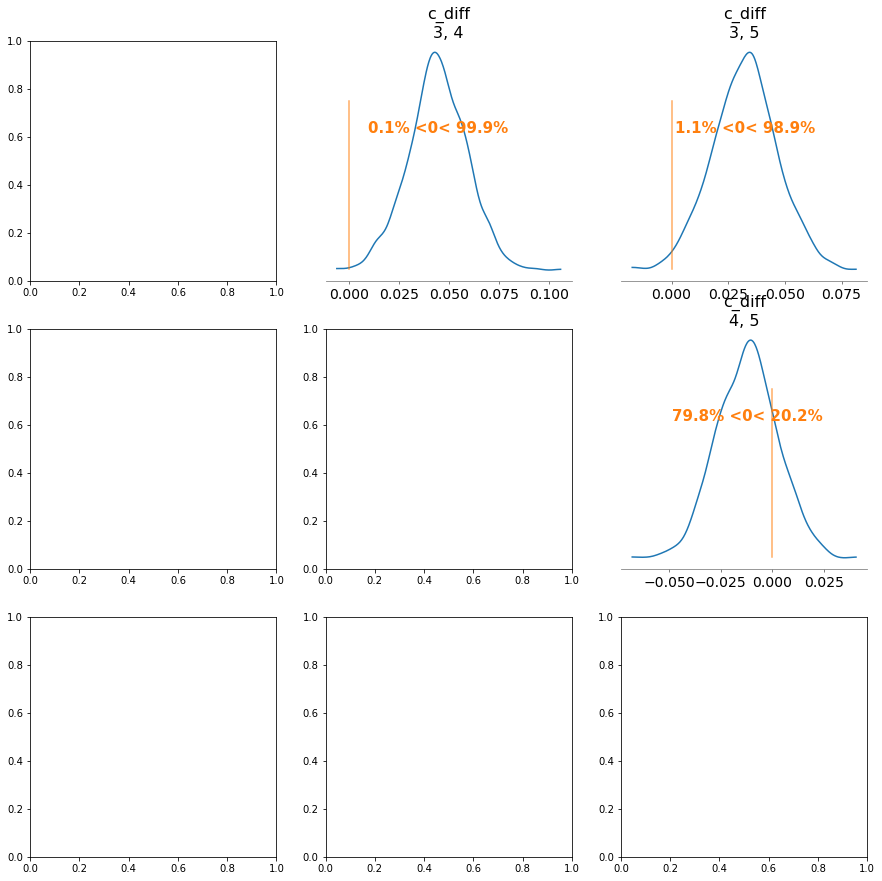

In [68]:
fig, axs = plt.subplots(3, 3, figsize=(15,15))
# axs[0, 0].plot(x, y)

for pair in [(3,4),(3,5),(4,5)]:
    coord={"obs_id":[pair[0]], "c_diff_dim_1":[pair[1]]}
    az.plot_posterior(glm_topic["trace"], var_names="c_diff", coords=coord, 
                      ref_val=0, hdi_prob='hide',point_estimate=None, ax=axs[pair[0]-3,pair[1]-3])


## Unit level data

In [9]:
# Rater, Topic model

glm_rater_topic["model"] = pm.Model()
with glm_rater_topic["model"]:
    # Hyperparameter priors
    raters = pm.Data("raters", rater_array, mutable=True, dims="obs_id")
    topics = pm.Data("topics", topic_array, mutable=True, dims=["cordel", "topic"])
    cordels = pm.Data("cordels", cordel_array, mutable=True, dims="obs_id")
    
    sigma_r = pm.Exponential("sigma_r", lam=r_lambda)
    zr = pm.Normal("zr",mu=0, sigma=1, shape=n_raters)
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
    za = pm.Normal("za",mu=0, sigma=t_sigma, shape=(n_cordels, n_topics)) 
    mu = pm.Normal("mu",mu=empirical_mean, sigma=mu_sigma)
    
    s = pm.Bernoulli(
            "s", 
            p=pm.math.invlogit(
                mu+
                za[topics[0],topics[1]]*sigma_a+
                zr[raters]*sigma_r),
            observed=score_array, 
            dims="obs_id")

    c_mean = pm.Deterministic("c_mean", 
                              pm.math.invlogit(mu + (za.T*sigma_a).T).mean(axis=1), 
                              dims="obs_id")
    
    glm_rater_topic["trace"]=pm.sample(cores=n_cores)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 109 seconds.


In [24]:
def create_summary_stat(trace, **args):
    summary_stat = az.summary(trace, round_to=4, **args).reset_index()

    # Creating parameter and parameter number columns
    summary_stat["param"] = summary_stat["index"].str.split("[").str[0]
    summary_stat["param_num"] = summary_stat["index"].str.split("[").str[1].str[:-1]
    summary_stat["param"] = summary_stat["param"].astype("category")
    summary_stat["param_num"] = summary_stat["param_num"].astype("category")
    return summary_stat[["param", "param_num"]+list(summary_stat.columns[1:-2])]

In [25]:
create_summary_stat(glm_topic["trace"], stat_funcs={"crit_val":lambda x:(x<0).sum()/x.shape[0]})

/home/roger/anaconda3/envs/bayes_topic_measures/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/roger/anaconda3/envs/bayes_topic_measures/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/roger/anaconda3/envs/bayes_topic_measures/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/roger/anaconda3/envs/bayes_topic_measures/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) 

,param,param_num,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,crit_val
0,za,"0, 0",-0.9597,0.3041,-1.5149,-0.3590,0.0057,0.0043,2918.0691,1028.4536,1.0044,1.0000
1,za,"0, 1",0.0336,0.3486,-0.5492,0.7490,0.0064,0.0092,3058.1800,1256.4594,1.0015,0.4710
2,za,"0, 2",0.1836,0.3564,-0.5026,0.8171,0.0057,0.0086,3963.4407,1247.2374,0.9995,0.3125
3,za,"0, 3",1.1571,0.5197,0.2598,2.1546,0.0089,0.0082,3621.4216,1541.3454,0.9999,0.0055
4,za,"0, 4",0.0319,0.3492,-0.5758,0.7492,0.0055,0.0085,4087.3217,1272.6452,1.0014,0.4845
...,...,...,...,...,...,...,...,...,...,...,...,...
339,c_diff,"5, 1",0.0650,0.0152,0.0356,0.0925,0.0002,0.0002,4667.0704,1396.7700,1.0003,0.0000
340,c_diff,"5, 2",0.0045,0.0142,-0.0233,0.0300,0.0002,0.0003,4283.0266,1606.1494,1.0018,0.3735
341,c_diff,"5, 3",-0.0323,0.0143,-0.0581,-0.0038,0.0002,0.0002,4347.4760,1369.3220,1.0059,0.9890
342,c_diff,"5, 4",0.0121,0.0147,-0.0147,0.0395,0.0002,0.0003,5043.4702,1440.9463,1.0032,0.2015
